In [2]:
from tsp_annealing import *
import matplotlib.pyplot as plt

In [3]:
opt_distance_51, opt_distance_280, opt_distance_442 = calculate_optimal_distances()

cities_51 = load_graph('TSP-Configurations/eil51.tsp.txt')
cities_280 = load_graph('TSP-Configurations/a280.tsp.txt')
cities_442 = load_graph('TSP-Configurations/pcb442.tsp.txt')

distances_51 = calculate_distances(cities_51)
distances_280 = calculate_distances(cities_280)
distances_442 = calculate_distances(cities_442)

In [4]:
def plot_TSP_solution(cities, permutation_method, opt_solution=None, **kwargs):
    plt.figure(figsize=(8, 6))
    plt.scatter([elem[0] for elem in cities], [elem[1] for elem in cities])
    plt.title('Map')

    distances = calculate_distances(cities)

    best_tour, best_distance, cost_over_iterations, temperature_over_interations, count = perform_annealing(distances, 
                                                                    altering_method=permutation_method, output_count=True, **kwargs)

    print("Best tour:", best_tour)
    print("Best distance:", best_distance)

    plot_tour(best_tour, cities, permutation_method)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(cost_over_iterations)
    if opt_solution is not None:
        opt_line = [opt_solution for _ in range(len(cost_over_iterations))]
        plt.plot(opt_line, linestyle='--', color='black')
    plt.title('Tour Distance Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Distance')
    plt.show()

    plt.plot(temperature_over_interations)
    plt.title('Temperature Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Temperature')

    plt.show()
    print('annealing iterations:', count)



def metrics(cities, permutation_method, print_results=True, **kwargs):
    distances = calculate_distances(cities)

    best_tour, best_tour_distance, _, _ = perform_annealing(distances, altering_method=permutation_method, **kwargs)

    best_tour_coordinates = tour_to_cities(best_tour, cities)

    if print_results:
        print('Method = \'%s\''%(permutation_method))
        print("Best distance:", best_tour_distance)
        print('With %i intersections \n'%(count_intersections(best_tour_coordinates)))
    
    return best_tour_distance, count_intersections(best_tour_coordinates)

def plot_dist_and_temp(costs, temps, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].set_title('Distance over iterations')
    axs[0].plot(costs)
    axs[1].set_title('Temperature')
    axs[1].plot(temps)
    if title is not None:
        fig.suptitle(title)
    plt.show()

In [5]:
cities = load_graph('TSP-Configurations/eil51.tsp.txt')

metrics(cities, 'swap')
metrics(cities, 'insert')
metrics(cities, 'reverse')

print('Actual optimal distance:', opt_distance_51)

Method = 'swap'
Best distance: 609.1151126506036
With 11 intersections 

Method = 'insert'
Best distance: 596.9998275583305
With 14 intersections 

Method = 'reverse'
Best distance: 487.9473694547435
With 1 intersections 

Actual optimal distance: 447.79299344253565


In [6]:
cities = load_graph('TSP-Configurations/a280.tsp.txt')

metrics(cities, 'swap')
metrics(cities, 'insert')
metrics(cities, 'reverse')

print('Actual optimal distance:', opt_distance_280)

Method = 'swap'
Best distance: 12261.922608478979
With 998 intersections 

Method = 'insert'
Best distance: 11598.528243661758
With 864 intersections 

Method = 'reverse'
Best distance: 9014.057395118134
With 520 intersections 

Actual optimal distance: 2586.7696475631606


In [8]:
cities = load_graph('TSP-Configurations/eil51.tsp.txt')
max_iterations = int(1E6)
final_temp = 1E-8
cooling_schedule = 'quadratic_a'
alpha = 1 - 1E-9
distances = calculate_distances(cities)

kwargs_list = [
    {
        'distances': distances,
        'altering_method': 'swap',
        'max_iterations': max_iterations,
        'final_temp': final_temp,
        'cooling_schedule': cooling_schedule,
        'alpha': alpha
    },
    {
        'distances': distances,
        'altering_method': 'insert',
        'max_iterations': max_iterations,
        'final_temp': final_temp,
        'cooling_schedule': cooling_schedule,
        'alpha': alpha
    },
    {
        'distances': distances,
        'altering_method': 'reverse',
        'max_iterations': max_iterations,
        'final_temp': final_temp,
        'cooling_schedule': cooling_schedule,
        'alpha': alpha
    }
]

start_time = time.time()
for kwargs in kwargs_list:
    perform_annealing(**kwargs)
end_time = time.time()
print('Time taken with NO concurrency', end_time - start_time)

output = run_concurrent(perform_annealing, param_sets=kwargs_list)

for i in range(3):    
    print(np.mean(output[i][1]))

Time taken with NO concurrency 66.70474219322205
Time taken with concurrency: 36.03011226654053 seconds


In [8]:
schedules = ['linear_a', 'linear_m', 'exponential_m']
max_iterations_list = range(100, 100200, 10000)
result = {}
for schedule in schedules:
    output = run_vary_maxiter_concurrent(num_runs=10, distances=distances_280, max_iterations_list=max_iterations_list,
                                         cooling_schedule=schedule, final_temp=1E-4, alpha=1 - 1E-4)
    result[schedule] = output

Time taken with concurrency: 79.99224781990051 seconds
Time taken with concurrency: 79.75093197822571 seconds
Time taken with concurrency: 82.35389804840088 seconds


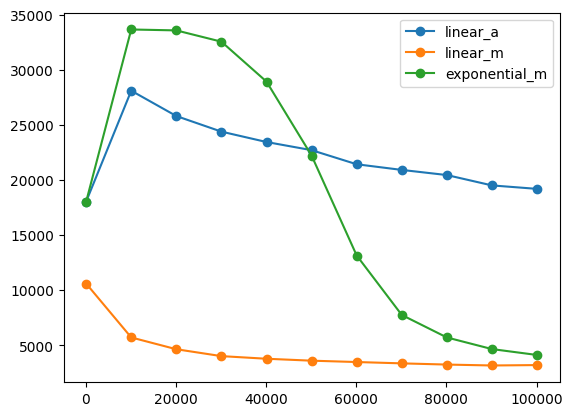

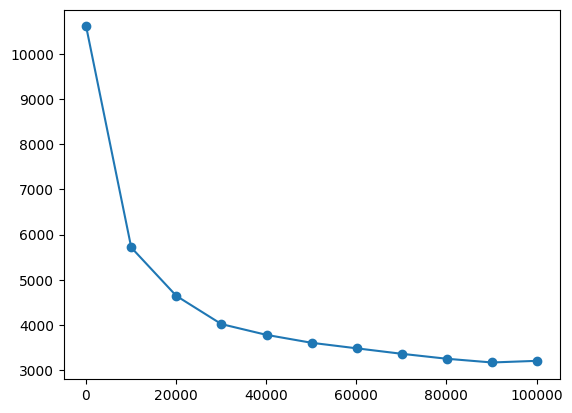

In [9]:
for schedule in schedules:
    plt.plot(max_iterations_list, result[schedule][0], 'o-', label=schedule)
    plt.legend()
plt.show()

plt.plot(max_iterations_list, result['linear_m'][0], 'o-')
plt.show()

In [34]:
schedules = ['linear_a', 'linear_m', 'exponential_m', 'quadratic_a', 'logarithmic_m']
alpha_list = [0.5, 1, 1-1E-4, 0.3, 1000]
max_iterations_list = range(1, 15200, 5000)

results_vary_schedules = {}
for i, schedule in enumerate(schedules):
    print(f'Running for schedule: {schedule}')
    output = run_vary_maxiter_concurrent_sims(num_runs=20, distances=distances_280, max_iterations_list=max_iterations_list,
                                         output='final_fitnesses', cooling_schedule=schedule, initial_temp=1E6, final_temp=1E-6, alpha=alpha_list[i], chain_length=3)
    results_vary_schedules[schedule] = output

Running for schedule: linear_a
Time taken (conc): 172.93219184875488
Running for schedule: linear_m
Time taken (conc): 157.34907150268555
Running for schedule: exponential_m
Time taken (conc): 40.19325566291809
Running for schedule: quadratic_a
Time taken (conc): 168.25037956237793
Running for schedule: logarithmic_m
Time taken (conc): 96.72606015205383


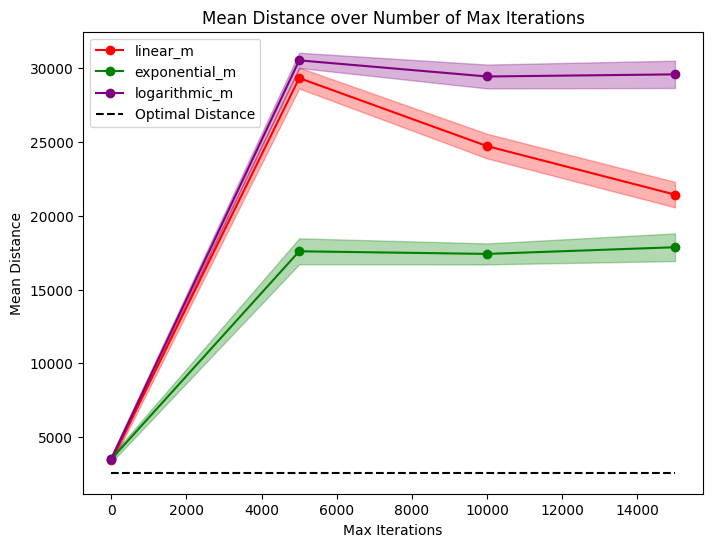

In [36]:
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'darkgreen', 'magenta']
for i, schedule in enumerate(schedules):
    if schedule in ['linear_a', 'quadratic_a', 'dynamic_m']:
        continue
    means = np.array([np.mean(elem) for elem in results_vary_schedules[schedule]])
    stds = np.array([np.std(elem) for elem in results_vary_schedules[schedule]])
    z_score = 1.96 

    conf_intervals = np.column_stack([
    means - z_score * (stds / np.sqrt(len(means))),
    means + z_score * (stds / np.sqrt(len(means)))
    ])

    lower_bounds = np.array([interval[0] for interval in conf_intervals])
    upper_bounds = np.array([interval[1] for interval in conf_intervals])

    plt.plot(max_iterations_list, means, marker='o', linestyle='-', color=colors[i], label=schedule)
    plt.fill_between(max_iterations_list, lower_bounds, upper_bounds, alpha=0.3, color=colors[i])
    
opt_distance_line = [opt_distance_280 for _ in max_iterations_list]

plt.plot(max_iterations_list, opt_distance_line, linestyle='--', color='black', label='Optimal Distance')
plt.title('Mean Distance over Number of Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel('Mean Distance')
plt.legend()
plt.show()